# Set up wind farm run

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
from matplotlib.lines import Line2D

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/lustre/orion/cfd162/proj-shared/lcheung/AWAKEN/Neutral/ABLDan'
precursorsetup= precursordir+'/precursor_5x5_newWD_restartwithPlanes2.inp'

# Location of farm run dir
farmrundir       = 'junk_setup/' #'/lustre/orion/cfd162/proj-shared/lcheung/AWAKEN/Neutral/4kmX2km_turbine1/'
outputfile       = '5x5_newWD_withTurbine.inp'
noturboutputfile = '5x5_newWD_noturbs.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
tstart = 20500 #chk65000 16125
tstop  = tstart+1000
textra = 0

In [5]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', 0.1)
case.setAMRWindInput('time.max_step',  -1)
case.setAMRWindInput('time.checkpoint_interval',1000)

In [6]:
# Set the restart point
chkdir = precursordir+'/chk41000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [7]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics40000.nc'
#tavg        =  [tstart, tstop]
tavg        = [20886.5, 20886.5+600]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo','ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_file.nc'

In [8]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/lustre/orion/cfd162/proj-shared/lcheung/AWAKEN/Neutral/ABLDan/bndry_file.nc'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.08812
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.08812
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [0.00014240761453906403, 0.0006295258556363406, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 41000


In [9]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0
OFoptions=""#("ADparam_TwrAero:True ADparam_TwrShadow:1 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
#           "EDparam_YawDOF:False "
#           "EDparam_PtfmSgDOF:False "
#           "EDparam_PtfmSwDOF:False "
#           "EDparam_PtfmHvDOF:False "
#           "EDparam_PtfmRDOF:False "
#           "EDparam_PtfmPDOF:False "
#           "EDparam_PtfmYDOF:False "           
#          )

#"EDparam_RotSpeed:5.00 "

## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     2000, 2560, Summit_GE2.8-127_ADM, 270.0, , {OFoptions}
""".format(OFoptions=OFoptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [10]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to T0_OpenFAST3p3_NREL2p8-127.bugfix
copy /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix failed
T0_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst


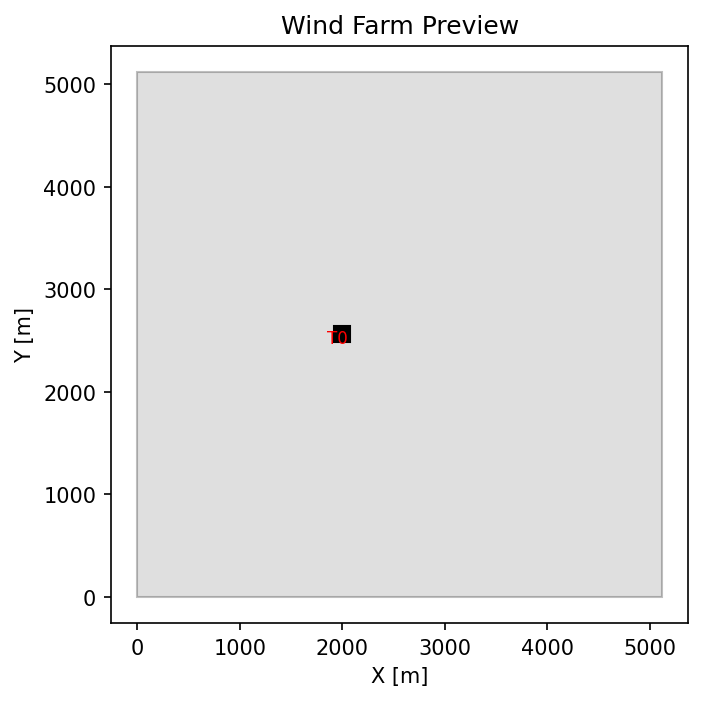

In [11]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

## Make refinement regions

In [12]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,     17,           6,       0.75,   4,   orientation:nacdir # (5m mesh)
1,     5,      15,           2.5,     0.75,   1.2, orientation:nacdir # (2.5m mesh)
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [13]:
case.refine_createAllZones()
# Print out existing list of refinement zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['T0_level_0_zone', 'T0_level_1_zone']


In [14]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     25165824             10.0 x 10.0 x 10.0
       1     25219691                5.0 x 5.0 x 5.0
       2     25563819                2.5 x 2.5 x 2.5
  TOTAL:     75949334


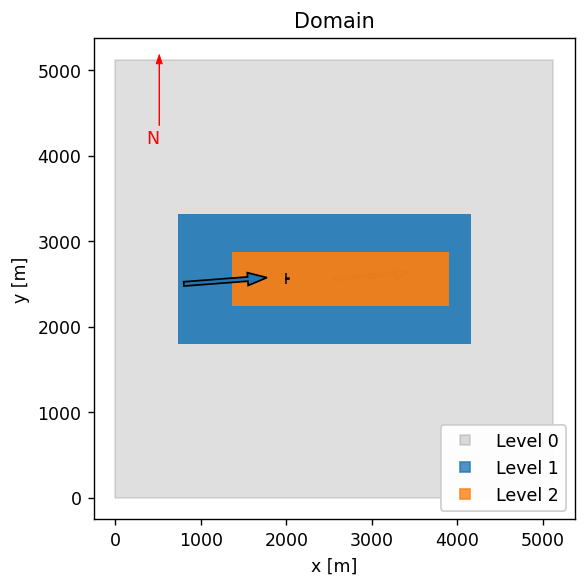

In [15]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = []
case.plotDomain(ax=ax2)
# put wind direction arrow here
winddir = 265.67
theta   = (270 - winddir)/180.0*np.pi
arrowdx = 750*np.array([np.cos(theta), np.sin(theta)])
ax2.arrow(800, 2500, arrowdx[0], arrowdx[1],width=50)

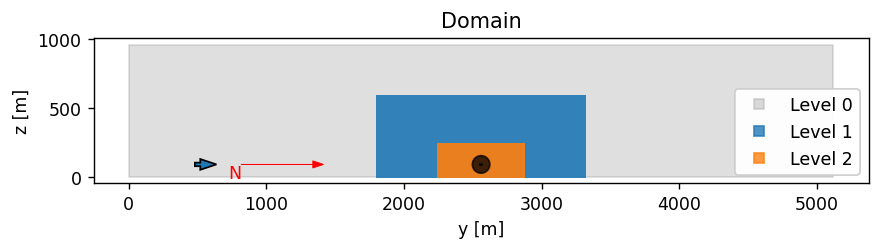

In [16]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Add sampling planes

In [17]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [18]:
# Set up averaging
pprosetup = case.get_default_postprosetupdict()
pprosetup['postprocessing_setup_name'] = 'sampling_'
pprosetup['postprocessing_setup_type'] = 'Sampling'
pprosetup['postprocessing_setup_output_frequency'] =  10
pprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature','tke']
case.add_postprosetup(pprosetup, verbose=True)


sampleplane = case.get_default_samplingdict()
# Modify the geometry
sampleplane['sampling_name']         = 'XYslice'
sampleplane['sampling_outputto']     = 'sampling_'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [513, 513]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [5120, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 5120, 0]
sampleplane['sampling_p_normal']     = [0, 0, 1]
sampleplane['sampling_p_offsets']    = '90.0'
case.add_sampling(sampleplane)

postprocessing_setup_name: 'sampling_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 10
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [19]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:10"

turbsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type,       upstream, downstream, lateral, below, above, n1, n2, options
turbhh,    hubheight,  10,       20,         4,       0,     1.5,     11, 11, usedx:0.05 outputto:turbhh_ orientation:nacdir {outputoptions} noffsets:1
sw,        streamwise, 10,       20,         0,       0.708, 1.5,     11, 11, usedx:0.05 outputto:turbsw_  orientation:nacdir {outputoptions}
swA,       streamwise, 10,       20,         4,       0.708, 1.5,     11, 11, usedx:0.05 outputto:turbswA_  orientation:nacdir {outputoptions} noffsets:2
swB,       streamwise, 10,       20,        -4,       0.708, 1.5,     11, 11, usedx:0.05 outputto:turbswB_  orientation:nacdir {outputoptions} noffsets:2
wakesw,    streamwise, 10,       20,         0,       0.708, 1.5,     11, 11, usedx:0.05 outputto:wakesw_  orientation:264.5 {outputoptions}
rotor,     rotorplane, 10,       20,         4,       0.708, 1.5,     11, 11, usedx:0.05  outputto:rotor_  orientation:nacdir outputvars:velocity noffsets:15  {outputoptions}
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', turbsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)
case.sampling_createAllProbes(verbose=True)

{'sampling_outputto': ['turbhh_'], 'sampling_name': 'T0_turbhh', 'sampling_type': 'PlaneSampler', 'sampling_p_num_points': [601, 161], 'sampling_p_origin': array([ 730., 2052.,   90.]), 'sampling_p_axis1': array([3810.,    0.,    0.]), 'sampling_p_axis2': array([  -0., 1016.,   -0.]), 'sampling_p_normal': array([0., 0., 1.]), 'sampling_p_offsets': '0.0 190.5'}
sampling_outputto: ['turbhh_']
sampling_name: 'T0_turbhh'
sampling_type: 'PlaneSampler'
sampling_p_num_points: [601, 161]
sampling_p_origin: array([ 730., 2052.,   90.])
sampling_p_axis1: array([3810.,    0.,    0.])
sampling_p_axis2: array([  -0., 1016.,   -0.])
sampling_p_normal: array([0., 0., 1.])
sampling_p_offsets: '0.0 190.5'
{'sampling_outputto': ['turbsw_'], 'sampling_name': 'T0_sw', 'sampling_type': 'PlaneSampler', 'sampling_p_num_points': [601, 45], 'sampling_p_origin': array([7.30e+02, 2.56e+03, 8.40e-02]), 'sampling_p_axis1': array([3810.,    0.,    0.]), 'sampling_p_axis2': array([  0.   ,   0.   , 280.416])}
sampli

In [20]:
#case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['XYslice', 'T0_turbhh', 'T0_sw', 'T0_swA', 'T0_swB', 'T0_wakesw', 'T0_rotor']


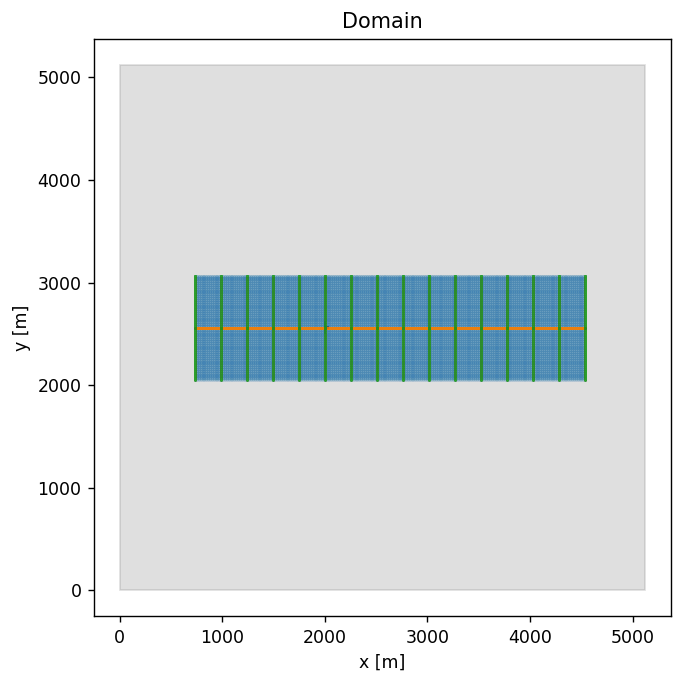

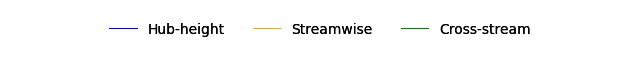

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['T0_turbhh', 'T0_sw', 'T0_rotor'] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.05, 'marker':'.', 'linestyle':'None'}"
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.plotDomain(ax=ax)
ax.get_legend().set_visible(False)

# And Legend
legfig, legax = plt.subplots(1, 1, figsize=(8, 0.75), dpi=100, sharey=True)
legax.axis('off')
legfontsize=10
legend1 = plt.legend([Line2D([0],[0], linestyle='-', color='b', lw=0.75), 
                      Line2D([0],[0], linestyle='-',  color='orange', lw=0.75), 
                      Line2D([0],[0], linestyle='-', color='g', lw=0.75),
                    ], 
                    ['Hub-height','Streamwise', 'Cross-stream'], 
                    fontsize=legfontsize, frameon=False, loc='upper center', ncol=3)
legax.add_artist(legend1)

## Print the input file

In [22]:
# Write the input file
#inputfile=case.writeAMRWindInput(outputfile)
#if verbose: print(inputfile)

### Create a version without turbines

In [23]:
#os.chdir(cwd)
#case.removeturbines()
#inputfile=case.writeAMRWindInput(noturboutputfile)
#if verbose: print(inputfile)